# Exploring Community Engagement with Multiple StackExchange Fora

### Bradley Carruthers, Candidate Number: 10140

## Table of Contents

* Abstract
* Introduction
* Datasets: StackExchange
* Distributed Computing Technology
* Conclusion
* References

## Abstract

Developing high-quality questions and procuring answers to these questions is not only fundamental to learning and information gathering, but to scientific progress as a whole. Online question-answer communities and fora have given internet-users the unprecendented ability of presenting questions to the world, and while much attention has been given to finding the right answers (ask Google), relatively little attention has been dedicated to how we can improve questions. This project explores over 1.2 million answers and questions from five of the largest StackExchange communities using distributed cloud computing technologies and uses natural language processing to uncover linguistic aspects of these answers and questions.

## Introduction

The advent of the world wide web has resulted in an unbelievably connected world, one where a single search engine will process up to [40 000 search queries every second or 3.5 billion a day](http://www.internetlivestats.com/google-search-statistics/). A number of dedicated question-answer communities also exist to directly and more rigorously answer the swarm of the world's daily questions, some of which include [Quora](quora.com), [Yahoo! Answers](answers.yahoo.com) and the family of dedicated fora, [StackExchange](https://stackexchange.com/sites#traffic).

I am interested in how these online question-answer communities interact with questions and how users can be nudged to improve questions before adding demand to expert resources in communities. This aim of this project therefore is an initial exploratory analysis of data on over 1.2 million answers and questions from various StackExchange fora relating to a variety of subject matter. Most importantly, by harnessing the capability of distributed cloud computing I am able to analyse datasets far larger than what is capable on a single, commercial machine.

The layout of the analysis is as follows: Firstly and secondly I give a brief discussion of the distributed computing technologies and data analysed. This is followed by an illustration of the setup code and the specific architecture of the computing capabilities I used. Various aspects of the data are then explored via Exploratory Data Analysis and t-SNE graphs, as well as through a Latent Dirichlet Allocation model that is implemented on post content to investigate latent topics and underlying semantic structure across each forum. Lastly, I conclude with a discussion on recommended further research.

## Distributed Computing Technologies

### Apache Spark

[Apache Spark](http://spark.apache.org) is a cluster-computing framework that is open-source and designed for to be fault-tolerant, distributed and use in-memory computing. [Apache Hadoop](http://hadoop.apache.org) is the distributed data storage and processing software framework underlying Spark, which uses the MapReduce programming model. The two main components of Hadoop are Hadoop Distributed File System (HDFS) and YARN. HDFS is the distributed file system handling large data, whereas YARN separates resource management and processing components.

Spark uses a master-slave architecture where there is one central coordinator or driver that communicates with many distributed workers or executors, illustrated by the following diagram:

<img src="img/spark-master-workers.png" style="width: 600px;" alt="big data htop one core">

While the driver and each executor run their own Java processes, the main method (SparkContext) runs on the driver process. The executors are processes on worker nodes that run individual tasks for a given Spark job - they launch at the beginning of a Spark initiation and will generally run until it ends. When tasks are completed, the executors relay results back to the driver.

The fundamental core class in Spark is the Resilient Distributed Dataset (RDD), put forth by Zaharia *et al.* (2012). RDDs are the distributed memory abstraction that allow programmers to use in-memory computation on large machine clusters in a fault tolerant way. The main finding from Zaharia *et al.* (2012) is that keeping data in-memory results improved performance by orders of magnitude.

Spark can be interfaced with various programming languages like Scala, Java, Python and R through respective APIs. In this Jupyter Notebook, my analysis will use the Python API, PySpark. 

This analysis primarily makes use of the class `pyspark.sql.DataFrame` within the Spark SQL module, which is used as a collection of data grouped into name columns. The Spark SQL module incorporates relational processing in Spark and thus benefits from optimised storage and declarative queries, as well as lets Structured Query Language (SQL) users use a host of analytics libraries in Spark (Armbrust *et al.*, 2015).

A more in-depth explanation of Spark can be found [here](https://www.learningjournal.guru/article/apache-spark/apache-spark-internals/).

**Note:** Although a rule of thumb is that Spark is best-suited for real-time or streaming data processing where a large amount of RAM is accessible and Hadoop is more suitable for batch processing using commodity hardware, I chose to use PySpark owing to its ease of use and access to the SQL-like API, Spark SQL.

An alternative to using PySpark would be Google BigQuery which is based on the Dremel technology. In short, the Dremel technology parallelises queries across a large number of Google servers and thus it is able to run SQL-like queries against extremely large datasets, obtaining results incredibly quickly. Users can upload their own datasets easily since BigQuery is integrated with Google Drive, Google Cloud BigTable and Google Cloud Storage. There are also a number of [public datasets](https://cloud.google.com/public-datasets/), one of which is the largest StackExchange question-answer site, StackOverflow. A deeper look into Google BigQuery is provided by Sato (2012).

## Datasets: StackExchange Family

StackExchange is a group of over 170 dedicated question-answer websites covering topics ranging from vegetarianism to robotics to science-fiction world building. The largest and oldest forum is programming site StackOverflow, now home to more than 10 million registered users and 18 million questions at the time of writing.

The data across all StackExchange sites are publicly available in XML format (zipped by 7-zip with bzip2 compression) at [archive.org](https://archive.org/download/stackexchange) and are regularly updated (the last update being 4 March 2019). For each site, the following files are available:

* `PostHistory.xml`: A history of the versions of each question and answer posted (questions can be edited)
* `Posts.xml`: The final, up to date version of each question and answer posted
* `Users.xml`: Data on registered users 
* `Votes.xml`: Data on different votes cast (moderator-related, offensive, spam, votes to close, delete etc.)
* `Comments.xml`: The final, up to date version of each comment posted
* `Badges.xml`: Log of when badges (an incentive mechanism) are awarded to users for specific achievements
* `PostLinks.xml`: Connects posts marked as linked or duplicated
* `Tags.xml`: Data on the tags put forth with each question posted

As this is an initial analysis, I will only be using the `Posts.xml` data for each forum. In this file, the following variables are recorded per post:

* `Id`: A chronological post identity variable
* `PostTypeId`: Mainly an indicator of whether the post is an question (==1) or an answer (==2)
* `ParentId`: An indicator of which question an answer belongs to (only answers)
* `AcceptedAnswerId`: An indicator of which answer the original question poster selected as accepted (only questions)
* `CreationDate`: A date variable relating to when the post was made
* `Score`: The difference between up-votes and down-votes for posts
* `ViewCount`: The number of times that a post has been viewed by registered and non-registered users alike
* `Body`: The main post content
* `OwnerUserId`: An identity variable for the post owner
* `LastEditorUserId`: An identity number for the last registered user that edited the post
* `LastEditDate`: A date variable relating to when the post was last edited
* `LastActivityDate`: A date variable relating to when last there was activity on the post
* `Title`: The post title (questions only)
* `Tags`: The collection of tags linked to a question
* `AnswerCount`: The number of answers that a question receives (questions only)
* `CommentCount`: The number of comments that a post receives
* `FavoriteCount`: The number of times that users have favourited a question (questions only)
* `ClosedDate`: A date variable relating to if the question was closed (questions only)

**Note:** The word "post" above refers to both questions and answers.

**Noteworthy aspects of the data**

It is worth mentioning the following:

* Not everyone who views a question (and thus adds to the `ViewCount`) can vote since you have to be a registered user to vote (the sites are open to the public) and you also need a certain amount of reputation to vote
* A [reputation](https://meta.stackexchange.com/questions/7237/how-does-reputation-work) level of 15 allows you to up-vote, whereas a level of 125 allows you to down-vote, thus the distribution of the `Score` variable is highly negatively skewed (more highly-scored questions and answers)
* Only a handful of the above variables will be used in this initial analysis

**Cluster and Environment Setup on Google Cloud Platform**

Google Cloud Platform (GCP) is the suite of Google's cloud computing services that run on the same infrastructure used at Google, a subset of which I use in this analysis. 

The services that are relevant for my analysis are the GCP Compute Engine and GCP Dataproc. The Compute Engine allows access to customisable virtual machines or instances which users can use for their computation needs, and Dataproc builds on this by offering a fully-managed cloud computing service to run Apache Spark and Hadoop clusters of virtual machines. I use Dataproc to specify the infrastructure of a master node and worker nodes - CPU options range from 1 to 96 cores per master and worker machine with the additional capability of specifying lower memory per machine (highcpu) or higher memory (highmem).

For this analysis, many different infrastructures of the GCP Dataproc clusters were explored to minimise read-in and run time. It appeared that scaling vertically was more fruitful than horizontally (at least for the intial queries), and thus I used a high-memory master node with 96 CPUs and no worker nodes. The code to spin up this specific GCP Dataproc cluster is shown below:

```bash
## set project beforehand
gcloud config list
export PROJECT="stack-exchange-project"
gcloud config set project ${PROJECT}

## set variables beforehand
export NUM_WORKERS="0"
export BUCKET="bucket-brad-project"
export CLUSTER="cluster-brad"

## spin up cluster
gcloud dataproc clusters create ${CLUSTER} \
--properties=^#^spark:spark.jars.packages=com.databricks:spark-xml_2.11:0.4.1 \
 --subnet default --zone europe-west2-a --master-machine-type n1-highmem-96 \
 --master-boot-disk-size 500 --num-workers=${NUM_WORKERS} --worker-machine-type n1-highmem-16 \
 --worker-boot-disk-size 500 --image-version 1.3-deb9 --project=${PROJECT} --bucket=${BUCKET} \
 --initialization-actions 'gs://dataproc-initialization-actions/jupyter/jupyter.sh',\
'gs://dataproc-initialization-actions/python/pip-install.sh','gs://bucket-brad-project/my-actions.sh' \
--metadata 'PIP_PACKAGES=sklearn nltk pandas'

## connect to jupyter notebook
export PORT=8123
export ZONE="europe-west2-a"
export HOSTNAME=cluster-brad-m

gcloud compute ssh ${HOSTNAME} \
    --project=${PROJECT} --zone=${ZONE}  -- \
    -D ${PORT} -N &

"/Applications/Google Chrome.app/Contents/MacOS/Google Chrome" \
      --proxy-server="socks5://localhost:${PORT}" \
      --user-data-dir=/tmp/${HOSTNAME}
```
```bash
## delete clusters after use
gcloud dataproc clusters delete cluster-brad
```

In order to use this large amount of resources on the GCP Dataproc cluster, I had to request the following quota increases from Google Cloud Support:

* Global and European `IN_USE_ADDRESSES` from 8 to 16
* European `CPUS` from 24 to 130
* Global `CPUS_ALL_REGIONS` from 32 to 520
* European `DISKS_TOTAL_GB` from 4096 to 5000


**Downloading the data**

The datasets were downloaded and moved over to a bucket on Google Cloud Storage using the following bash script, which was run when the GCP cluster is created:

```bash
## install htop to monitor CPUs later
sudo apt-get install htop

## install unzipper
sudo apt-get install --yes p7zip-full

## create folder and datasets array (separate approach for stackoverflow.com-Posts.7z)
mkdir datasets && cd datasets

declare -a arr=(
"askubuntu.com"
"codegolf.stackexchange.com"
"codereview.stackexchange.com"
"es.stackoverflow.com"
"math.stackexchange.com"
"physics.stackexchange.com"
"ru.stackoverflow.com"
"stackoverflow.com-Posts"
"superuser.com"
"unix.stackexchange.com"
)

## loop downloading, unzipping and extracting all XML data
for i in "${arr[@]}"
do
   mkdir "$i" && cd "$i"
   wget https://archive.org/download/stackexchange/"$i".7z
   p7zip -d "$i".7z
   find . -type f ! -name 'Posts.xml' -delete # delete everything except Posts.xml
   cd ..
   echo "On to next dataset!"
done

## rename folders for ease of import later
mv stackoverflow.com-Posts stackoverflow.stackexchange.com
mv superuser.com superuser.stackexchange.com
mv askubuntu.com askubuntu.stackexchange.com
mv ru.stackoverflow.com rus_stackoverflow.stackexchange.com
mv es.stackoverflow.com es_stackoverflow.stackexchange.com

cd

## copy datasets folder over to bucket
gsutil cp -r datasets gs://bucket-brad-project/datasets/large-datasets
```

Lastly it should be noted that while this work is only an inital analysis of a few datasets, it will serve as a stepping stone to predict a community engagement with questions so that users can be nudged to improve aspects of their questions before adding demand to expert resources in a community. This notebook lays the groundwork for a planned classification project analysing a greater collection of larger datasets in a distributed computing framework.

---

# Analysis

## Importing and Setup

In [5]:
## testing printing output from console
import subprocess
cmd = [ 'echo', '"Welcome to my notebook"' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

b'"Welcome to my notebook"\n'


In [6]:
## use com.databricks package specified when spinning up cluster
import os ## restart kernel
#os._exit(00)
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.4.1 pyspark-shell'

In [7]:
## check default number of partitions
sc.defaultParallelism

8

In [9]:
## import standard libraries
import re
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

## import pyspark elements
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.functions import col, lit, when
from pyspark.sql import Row

## import elements from natural language toolkit
import nltk
#nltk.download('all') # uncomment first run as admin check
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

## function to tokenise and lemmatise
# Milan Vojnovic and Christine Yuen, Simon Schoeller
def get_tokens(line):
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

## set checkpoint directory
sc.setCheckpointDir("gs://bucket-brad-project/tmp/")

## Loading Data

In [14]:
## choose datasets to compare
data_array = [
"codegolf",
"codereview",
"es_stackoverflow",
"physics",
"unix"
]

Owing to difficulties in processing speeds that will be detailed shortly, I chose to analyse only the above datasets, information on which is displayed in the table below:

| Fora | Registered Users | Questions | Answers | Posts.xml Size | Description |
| --- | --- | --- | --- | --- | --- |
| codegolf | 68k | 11k | 137k | 272.74 MB | Programming puzzles |
| codereview | 171k | 59k | 94k | 596.56  MB | Peer programmer code reviews |
| es_stackoverflow | 115k | 89k | 100k | 420.67 MB | Spanish StackOverflow |
| physics | 167k | 137k | 202k | 509.59 MB | Physics related |
| unix | 311k | 159k | 242k | 577.06 MB | Linux, FreeBSD and other Un*x-like operating systems

In [15]:
## point to right directory
fpath = 'gs://bucket-brad-project/datasets/large-datasets/'

## function to extract data from xml files
# Milan Vojnovic and Christine Yuen, edited by Simon Schoeller
def load_all_xml(table_name):
    # create dataframe list skeleton
    dfs = {}
    xml_name = table_name.capitalize()
    for i in data_array:
        table = sqlContext.read.format('com.databricks.spark.xml').options(rowTag=table_name).load(fpath+i+'.stackexchange.com/'+xml_name+'.xml')
        rdd_table = table.rdd.flatMap(lambda x: x).flatMap(lambda x: x).repartition(96) # key step
        # assign dataframe to list entry
        dfs[i] = sqlContext.createDataFrame(rdd_table, table.schema.fields[0].dataType.elementType)
        dfs[i].createOrReplaceTempView(table_name)
    return dfs

In [16]:
## display architecture of master node
import multiprocessing
print("Number of CPUs master node:", multiprocessing.cpu_count())

## testing printing output from console
import subprocess
cmd = [ 'grep', 'MemTotal', '/proc/meminfo' ]
output = subprocess.Popen( cmd, stdout=subprocess.PIPE ).communicate()[0]
print(output)

Number of CPUs master node: 96
b'MemTotal:       643995876 kB\n'


In [39]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

## extract all datasets and store in list of dataframes
posts_dfs = load_all_xml("posts")

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") 

Start time: 09:29:12.115888
Time taken: 17 minutes.


Much time was spent testing out cluster architectures since initially just the loading-in of the smallest of the 10 datasets was taking a substantial amount of time. Eventually due to time and GCP budget constraints, I chose to anlayse only the 5 smallest datasets downloaded (a total of just over 2gb of data) and scaled my resources vertically as opposed to horizontally, choosing a high-memory master node with 96 CPUs.

Examples of cluster architectures and the time taken to read in the respective forums are displayed below:

| Master Node | Workers | Read-In Time | Fora |
| --- | --- | --- | --- |
| n1-highcpu-32 | 4 x n1-highcpu-8 | > 7 min | codereview |
| n1-highcpu-32 | 7 x n1-standard-4 | 7 min | codereview |
| n1-highmem-32 | 2 x n1-standard-8 | 4 min | codereview |
| n1-highmem-96 | 2 x n1-highmem-96 | 4 min | codereview |
| n1-standard-32 | 2 x n1-standard-4 | 4 min | codereview |
| n1-highcpu-32 | 2 x n1-standard-4 | 4 min | codereview |
| n1-standard-64 | 2 x n1-standard-4 | 4 min | codereview |
| n1-highmem-32 | 2 x n1-standard-4 | 4 min | codereview |
| n1-highmem-32 | 2 x n1-highmem-4 | failed | es_stackoverflow, codereview, physics, unix |
| n1-highmem-96 | 2 x n1-highmem-16 | 12 min | codereview, physics, unix |
| n1-highmem-32 | 2 x n1-highmem-4 | 11 min | codereview, physics, unix |
| n1-highmem-96 | 0  | 17 min | es_stackoverflow, codegolf, codereview, physics, unix |


From the table we can see that increasing the workers and memory doesn't appear to increase speed of read-in. Increasing the CPUs of the master node apparently matters the most (although the gain in speed for using so many CPUs leaves much to be desired). While this may indicate resource bottlenecking on the master CPUs, a much more likely explanation is that the full capacity of the cores of the master and workers is not being used when issuing PySpark commands, and htop provides evidence for this:

<img src="img/htop-screenshot.png" style="width: 900px;" alt="big data htop one core">

This is a common theme throughout the initial analysis with PySpark commands failing if there weren't enough cores on the master worker. It was originally thought that this was due to the original data being stored in XML format [as this appears to be an issue in some cases](https://community.hortonworks.com/questions/78024/comdatabrickssparkxml-parsing-xml-takes-a-very-lon.html), but it is also possible that the underlying Spark installation beneath PySpark is having trouble using the cores across the master and workers effectively resulting in very high computation times for data read-in and basic queries on relatively small datasets. While much troubleshooting was undergone to address this problem, it remained throughout most of the analysis and consequently not all 10 largest StackExchange datasets (let alone 20) were analysed. Nevertheless, this notebook allows for the reproducibility of the analysis with larger datasets if this particular issue is addressed.

In [2]:
## troubleshooting
#sc._conf.getAll()
#sc.stop()
#sc = SparkContext("local[*]", "Test")
#sc._conf.getAll()

**A note on the data**

An interesting aspect of the data is that while it is initially in raw XML format which is considered **semi-structured** since it contains tags/markers to enforce hierarchy of entries, I read-in the data to a `pyspark.sql.DataFrame` which has a schema and is thus **structured**. The final `Body` variable I work with is completely **unstructured** since as text it is not organised in any manner.

**Testing to see if repartitioning data speeds up analysis**

In [41]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

## count rows of first dataset
print(posts_dfs["codegolf"].count())
    
## end time
T = time.time() - t0;
print("Time taken:", T/60, "minutes.") 

Start time: 09:46:37.584317
145539
Time taken: 3.021807797749837 minutes.


In [46]:
## repartition
for i in data_array:
    posts_dfs[i] = posts_dfs[i].repartition(384)
    print(posts_dfs[i].rdd.getNumPartitions())

384
384
384
384
384


In [47]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

## count rows of first dataset
print(posts_dfs["codegolf"].count())
    
## end time
T = time.time() - t0;
print("Time taken:", T/60, "minutes.") 

Start time: 09:57:32.823280
145539
Time taken: 3.1331292430559796 minutes.


After trying a number of partitions from 4 to 384, it appears that this has little to no effect on computation speed. Again, the issue of only a few cores being used is present:

<img src="img/htop-screenshot-2.png" style="width: 900px;" alt="big data htop two cores">

# Exploratory Data Analysis (EDA)

In [48]:
# print type of posts_dfs
print(type(posts_dfs))
print('\n')

# print type of first dataframe
print(type(posts_dfs["codereview"]))
print('\n')

# schema of first dataframe
posts_dfs["codereview"].printSchema()

<class 'dict'>


<class 'pyspark.sql.dataframe.DataFrame'>


root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable = true)
 |-- _LastEditDate: string (nullable = true)
 |-- _LastEditorDisplayName: string (nullable = true)
 |-- _LastEditorUserId: long (nullable = true)
 |-- _OwnerDisplayName: string (nullable = true)
 |-- _OwnerUserId: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: long (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _ViewCount: long (nullable = 

To save computation time, we drop columns we don't need:

In [50]:
## start time
t0 = time.time()
print("Start time:", datetime.now().time())

for i in data_array:
    posts_dfs[i] = posts_dfs[i].select('_AnswerCount', '_Body', '_CommentCount', '_PostTypeId', '_Score', '_ViewCount')
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") 

Start time: 10:02:51.643357
Time taken: 0 minutes.


We can see how PySpark commands are lazily evaluated since the above command is almost instantaneous.

In [52]:
## garbage collector to speed up computation
import gc
collected = gc.collect()
print("Garbage collector: collected %d objects." % collected)

Garbage collector: collected 473 objects.


In [54]:
## start time
t0 = time.time()
print(datetime.now().time())

for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print(posts_dfs[i].select('_AnswerCount', '_CommentCount', '_PostTypeId', '_Score', '_ViewCount').describe().show())
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 36 minutes all-5

10:10:21.740725

------------------
 codegolf 
------------------

+-------+------------------+-----------------+------------------+-----------------+------------------+
|summary|      _AnswerCount|    _CommentCount|       _PostTypeId|           _Score|        _ViewCount|
+-------+------------------+-----------------+------------------+-----------------+------------------+
|  count|             10389|           145539|            145539|           145539|             10389|
|   mean|12.940128982577727|1.915184246147081|1.9412322470265702|5.129518548292897|2338.6605063047455|
| stddev| 20.86264087761769|3.375810436163644|0.3194763857462286| 13.6708923054352|7544.9500355821165|
|    min|                 0|                0|                 1|              -35|                17|
|    max|               733|               94|                 7|             1277|            433789|
+-------+------------------+-----------------+------------------+-----------------+------------------+

None


Above we see descriptive statistics for selected variables, a selection of which are graphed below.

10:46:30.316033
Time taken: 32 minutes.


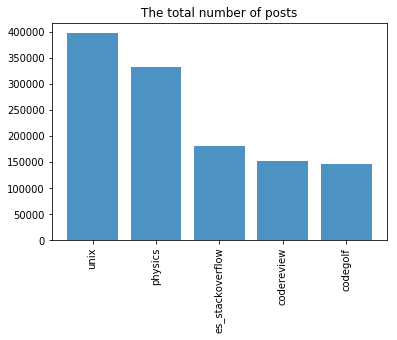

In [55]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## total number of posts of fora
for i in data_array:
    plot_data[i] = posts_dfs[i].count()

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") 
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 32 minutes all-5
    
## bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('The total number of posts')
plt.show()

Interestingly, the order of dataset size from largest to smallest is `codereview`; `unix`; `physics`; `codegolf`; `es_stackoverflow` which differs from the count of posts across the fora. Evidently `codereview` and `codegolf` have few posts that contain a lot of data compared to the other datasets.

11:21:32.118604
Time taken: 30 minutes.


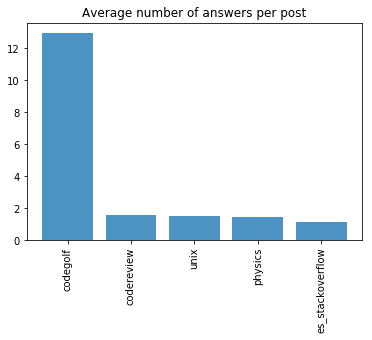

In [56]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## total number of answers per post of fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_AnswerCount').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 30 minutes all-5

## bar plot of answers per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average number of answers per post')
plt.show()

From the above graph it is clear that there are substantially more answers per post for the small number of posts on the `codegolf` forum. Since `codegolf` is a code-puzzle forum, this shows the high level of engagement the community engages with an average post.

11:51:50.519251
Time taken: 28 minutes.


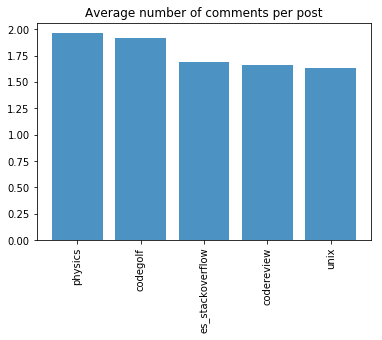

In [57]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## total number of comments per post of fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_CommentCount').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 28 minutes all-5


## bar plot of comments per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average number of comments per post')
plt.show()

There appears to be very little variation in the number of comments per post, with the average across all fora appearing to be close to two comments per post.

12:20:03.116557
Time taken: 29 minutes.


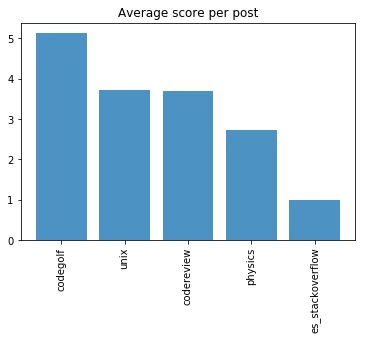

In [58]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## average score per post across fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_Score').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 23 minutes codereview, physics, unix
# hm96 - 29 minutes all-5
    
## bar plot of score per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Average score per post')
plt.show()

`codegolf` has the highest Score per post at a value of around 5, whereas `es_stackoverflow` has the lowest - closer to 1.

12:48:58.930877
Time taken: 29 minutes.


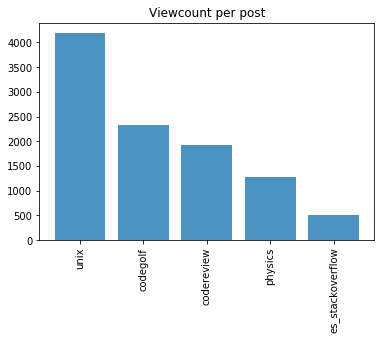

In [59]:
## empty dictionary of df skeleton
plot_data = {}

## start time
t0 = time.time()
print(datetime.now().time())

## average viewcount per post across fora
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_ViewCount').collect()[0][0]

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 24 minutes codereview, physics, unix
# hm96 - 29 minutes all-5
    
## bar plot of viewcount per post in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Viewcount per post')
plt.show()

The `unix` forum has a substantially larger average `Viewcount` per post compared to other fora.

13:18:16.806485
Time taken: 29 minutes.


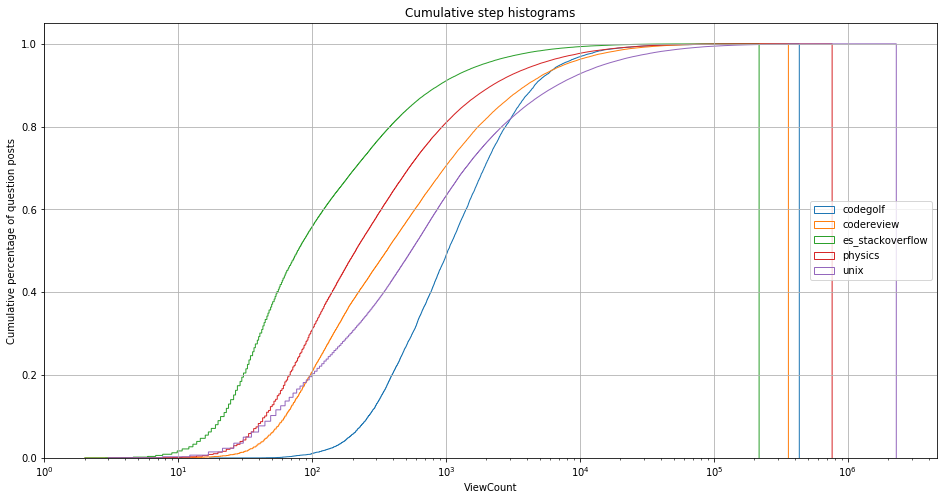

In [60]:
## start time
t0 = time.time()
print(datetime.now().time())

## create plot data for cumulative viewcount
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].select('_ViewCount').rdd.flatMap(lambda x: x).collect()
    plot_data[i] = [x for x in plot_data[i] if x is not None]
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.")
# hm96;2xhm16 - 23 minutes codereview, physics, unix
# hm96 - 29 minutes all-5

## plot cumulative distribution of viewcount across fora
n_bins = 500000
fig, ax = plt.subplots(figsize=(16, 8))
for i in data_array:
    n, bins, patches = ax.hist(plot_data[i], n_bins, density=True, histtype='step',
                               cumulative=True, label=i)
ax.grid(True)
ax.set_xscale('log')
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('ViewCount')
ax.set_ylabel('Cumulative percentage of question posts')
plt.show()

The above graph plots cumulative percentages of posts as a function of `ViewCount`. The two different aspects that are interesting are the order of the curves from left to right, and the instances of curves intersecting. 

A graph further left is indicative of low `ViewCounts` per post and corresponds to the `ViewCount` bar graph displayed above - this is evident since `es_stackoverflow` is furthest left whereas `unix` and `codegolf` are furthest right. 

The crossings of the curves indicate that there are certain `ViewCount` thresholds where forums become more popular (experience more viewing traffic) than others. For example, for low `ViewCount` posts between 100 and just over 1000, the `codegolf` forum has the highest views per post, but after a certain point the `unix` forum appears to have more popular posts. This also shows that there are particular posts in the `unix` forum that are very highly viewed, most likely because they hold much utility to individuals working and programming in unix environments. Interestingly though, the same curve shape does not hold for `es_stackoverflow` where we would assume particular posts would also have high-value to the community.

Overall, it appears as though the `ViewCount` distributions across fora are not homogenous.

# Natural Language Processing

In [ ]:
## garbage collector to speed up computation
import gc
collected = gc.collect()
print("Garbage collector: collected %d objects." % collected)

In [61]:
## extract Body from fora
body_data = {}
for i in data_array:
    body_data[i] = posts_dfs[i].select("_Body").rdd.flatMap(lambda r: r)

In [69]:
## start time
t0 = time.time()
print(datetime.now().time())

## look at first post from physics
print(body_data['physics'].take(1))

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 8 minutes all-5

14:02:10.136339
['<p>We live in the age of measurements and observations and specific mathematical theories that fit measurements and observations beyond any doubt.</p>\n\n<p>Photons are <a href="https://en.wikipedia.org/wiki/Elementary_particle" rel="nofollow">elementary particles.</a> . They have zero mass, and other characteristics which separate them from other elementary particles .  </p>\n\n<blockquote>\n  <p>Can photons lose a small amount of energy over time when traveling large distances due to either weak interactions with magnetic fields (Faraday Effect) </p>\n</blockquote>\n\n<p>This is an electromagnetic vertex for a photon, the faraday effect is for the emergent light beam from innumerable photons. </p>\n\n<blockquote>\n  <p>or due to the way all objects cool and give off thermal radiation (Second law of Thermodynamics)</p>\n</blockquote>\n\n<p>No elementary particles behave thermodynamically. Thermodynamics is an emergent theory over many particles (statistical mechanics

Above we see an example of the body of a post in the `physics` forum

### Tokenising and lemmatising

Here we use the predefined `get_tokens` that uses elements of the `nltk` package to parse the text of each post's `Body` across the five fora. Tokenisation extracts individual words from the corpora and lemmatisation groups inflected words together.

In [63]:
## tokenise and lemmatise using nltk function from import step
body_rdd = {}
for i in data_array:
    body_rdd[i] = body_data[i].map(lambda line: (1, get_tokens(line)))

Again we check the number of partitions for the token- and lemmatised list of `rdd` objects we have just created

In [67]:
## check partitions for body_rdd
for i in data_array:
    print(body_rdd[i].getNumPartitions())

384
384
384
384
384


In [71]:
## start time
t0 = time.time()
print(datetime.now().time())

## look at first 10 terms from first post in physics
print(body_rdd['physics'].take(1)[0][1][:10])

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 8 minutes all-5

14:03:16.873793
['p', 'live', 'age', 'measurement', 'observation', 'specific', 'mathematical', 'theory', 'fit', 'measurement']
Time taken: 0 minutes.


Above we see an example of the tokens extracted from the first post from the `physics` forum.

In [75]:
## start time
t0 = time.time()
print(datetime.now().time())

# get rid of stop words
doc_stop_words = {}
for i in data_array:
    doc_stop_words[i] = body_rdd[i].flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
    # here we assume that words that appear very frequently are stop words
    doc_stop_words[i] = doc_stop_words[i].filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()
    # remove stopwords and single letters
    body_rdd[i] = body_rdd[i].map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words[i] and not len(w)==1]))
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 21 minutes all-5

14:08:25.248992
Time taken: 21 minutes.


### Converting tokens into sparse vectors

In [77]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

## convert tokens into sparse vectors
body_df = {}
for i in data_array:
    body_df[i] = spark.createDataFrame(body_rdd[i], ["dummy","words"])
    body_df[i].cache()

In [79]:
## start time
t0 = time.time()
print(datetime.now().time())

## check 10 first codegolf vector
print(body_df['codegolf'].take(1))

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 8 minutes all-5  

14:33:15.015997
[Row(dummy=1, words=['wwwrprojectorg', 'giuseppe', 'langr', 'scan', 'rc', 'colsums', 'ggg'])]
Time taken: 0 minutes.


### Generating vectors that are [histograms](https://spark.apache.org/docs/latest/ml-features.html#countvectorizer) of word counts associated with each document

In [82]:
## start time
t0 = time.time()
print(datetime.now().time())

cntvcr = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cntvcr_models = {}
word_feat_list = {}
for i in data_array:
    cntvcr_models[i] = cntvcr.fit(body_df[i])
    word_feat_list[i] = cntvcr_models[i].transform(body_df[i])
    word_feat_list[i].cache()

## show word vectors and feature counts for fora:
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    word_feat_list[i].show(10)


## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 4 minutes all-5  

14:43:50.132139

------------------
 codegolf 
------------------

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[wwwrprojectorg, ...|(91392,[307,375,7...|
|    1|       [batch, seta]|(91392,[604,4107]...|
|    1|[nodejs, repl, la...|(91392,[176,182,6...|
|    1|[igsub, stranger,...|(91392,[17,23,100...|
|    1|[efil, thought, f...|(91392,[105,209,3...|
|    1|[csystemconsole, ...|(91392,[225,5940,...|
|    1|[carriage, cr, br...|(91392,[430,1208,...|
|    1|[slug, jmz, jmp, ...|(91392,[0,95,607,...|
|    1|[githubcomstevenh...|(91392,[291,1705,...|
|    1|[нœiмà, нœiмà, ex...|(91392,[773,2217,...|
+-----+--------------------+--------------------+
only showing top 10 rows


------------------
 codereview 
------------------

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|   

### Converting pyspark.ml vectors to pyspark.mllib vectors

In [84]:
from pyspark.mllib.linalg import Vectors
def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = {}
feature_vec_list = {}
for i in data_array:
    features[i] = word_feat_list[i].select("features")
    feature_vec_list[i] = features[i].rdd.map(lambda r: as_mllib_vector(r[0]))
    feature_vec_list[i].cache()

## print first pyspark.mllib vectors for fora:
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print(feature_vec_list[i].take(1))


------------------
 codegolf 
------------------

[SparseVector(91392, {307: 1.0, 375: 1.0, 731: 1.0, 1578: 1.0, 2643: 1.0, 6604: 1.0, 9392: 1.0})]

------------------
 codereview 
------------------

[SparseVector(262144, {60: 6.0, 1669: 3.0, 2694: 3.0, 3692: 4.0, 5618: 3.0, 6921: 3.0, 11805: 3.0, 14240: 2.0, 25446: 1.0, 52424: 2.0, 170345: 3.0, 171994: 3.0, 213282: 2.0, 222969: 2.0})]

------------------
 es_stackoverflow 
------------------

[SparseVector(262144, {338: 1.0, 865: 1.0, 2974: 1.0, 6867: 1.0, 11137: 1.0, 11471: 1.0, 12215: 3.0, 17204: 2.0, 19730: 1.0, 21019: 1.0, 22044: 1.0, 31778: 1.0})]

------------------
 physics 
------------------

[SparseVector(109986, {1: 1.0, 121: 1.0, 168: 1.0, 176: 1.0, 248: 1.0, 314: 2.0, 358: 2.0, 406: 1.0, 501: 1.0, 894: 1.0, 944: 1.0, 1302: 1.0, 1680: 1.0, 1803: 1.0, 2071: 2.0, 2407: 1.0, 2809: 1.0, 4292: 1.0, 4356: 1.0, 4498: 1.0, 6028: 1.0, 6999: 1.0, 9405: 1.0, 10236: 1.0, 14423: 1.0, 77164: 1.0, 83876: 1.0})]

------------------
 uni

Converting the vectors allows us to use the SVD algorithm from Spark. Above are representations of the sparse pyspark.mllib vectors.

### Now we can take a look at the first 100 words of the vocabulary

In [86]:
## print first 100 words 
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    print ("Vocabulary from CountVectorizerModel is:\n")
    print(cntvcr_models[i].vocabulary[:100])
    print("\n---\n")

    M = len(cntvcr_models[i].vocabulary)
    print("Number of terms M = ", M)


------------------
 codegolf 
------------------

Vocabulary from CountVectorizerModel is:

['throw', 'leading', 'questionstaggedcodegolf', 'action', 'compute', 'trick', 'old', 'anonymous', 'quite', 'plus', 'update', 'builtin', 'wall', 'powershell', 'target', 'bonus', 'quot', 'symbol', 'containing', 'ho', 'programming', 'corresponding', 'infinite', 'separated', 'lower', 'half', 'draw', 'tbody', 'twice', 'level', 'third', 'written', 'xy', 'defined', 'minute', 'fact', 'stop', 'condition', 'invalid', 'dyalog', 'num', 'lowercase', 'continue', 'self', 'blue', 'modulo', 'jump', 'via', 'printing', 'ord', 'japt', 'basic', 'tp', 'message', 'remaining', 'actual', 'little', 'shift', 'adding', 'nn', 'requires', 'hodor', 'real', 'choose', 'circle', 'able', 'instance', 'concatenate', 'sign', 'expected', 'later', 'formula', 'alphabet', 'beginning', 'body', 'search', 'abc', 'including', 'io', 'support', 'big', 'help', 'tree', 'encoding', 'ba', 'langhtml', 'inside', 'within', 'yes', 'choice', 'due', '

An interesting anomaly is the name of the TV show Game of Thrones character "Hodor" showing up in the `codegolf` forum of all places.

##  Latent Semantic Analysis (SVD)

Latent Semantic Analysis is an automatic indexing and retrieval technique by Deerwester *et al.* (1990) that uses the singular value decomposition (SVD) of a term-document matrix to uncover latent factor loadings. More specifically, the left and right singular vectors of the SVD represent the latent term and document factor loadings.

Computing the SVD requires a parameter `k`, defined as the number of latent factors, to be specified. I choose a value of 5, however further analysis could investigate results when this parameter is varied.

In [88]:
## start time
t0 = time.time()
print(datetime.now().time())

from pyspark.mllib.linalg.distributed import RowMatrix

feature_mat_list = {}
for i in data_array:
    feature_mat_list[i] = RowMatrix(feature_vec_list[i])

# Here we use the dimension of latent factors to be k
k = 5
feature_svd_list = {}
U_list = {}
s_list = {}
V_list = {}
for i in data_array:
    feature_svd_list[i] = feature_mat_list[i].computeSVD(k, computeU=True)
    U_list[i] = feature_svd_list[i].U       # The U factor is a RowMatrix.
    s_list[i] = feature_svd_list[i].s       # The singular values are stored in a local dense vector.
    V_list[i] = feature_svd_list[i].V       # The V factor is a local dense matrix.
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 5 minutes all-5  

14:56:02.296046
Time taken: 5 minutes.


In [89]:
## print number of documents and terms for codegolf forum
print("number of rows of U", U_list['codegolf'].numRows()) # this is the number of documents (N)
print("number of rows of V", V_list['codegolf'].numRows ) # this is the number of terms (M)

number of rows of U 145539
number of rows of V 91392


Above we see that the number of rows for the `U` matrix correspond precisely with the number of documents in the initial EDA results for the `codegolf` forum, and the number of rows for the `V` matrix correspond to the number of terms previously found.

In [90]:
## an example of U factors, V factors and singular values for codegolf forum
collected = U_list['codegolf'].rows.take(10)

print("U factors for expatriate forum are:")
for vector in collected:
    print(vector)
    
print("Singular values are: \n", s_list['codegolf'])

print("V factors are: \n", V_list['codegolf'])

U factors for expatriate forum are:
[1.8125027388697233e-08,-2.0324541632366923e-11,-7.175277808477548e-10,3.495786681817518e-10,-1.9015818378546935e-07]
[2.937507823227578e-10,-1.2620569810432825e-08,-1.6944603654528644e-10,9.997322450703687e-11,-2.894662855071321e-08]
[1.3595755814344951e-08,-2.3021141037820016e-10,-2.5656813306792763e-09,1.7000031648800764e-09,-1.0674325487483314e-06]
[1.8671405227754274e-08,-5.904802643979891e-10,-3.5532929337836493e-07,3.5133571465694577e-07,-6.038340264592165e-06]
[1.7269408327738678e-08,-1.2808188275317865e-08,-4.518738725440523e-07,9.22624420404258e-10,-7.410721700937549e-07]
[1.0135708826111737e-09,-1.4932534185210453e-11,-6.005044563769248e-10,2.150890349965929e-10,-1.5244671821487693e-07]
[3.209771465659276e-09,-3.710850571717162e-11,-6.305666498602037e-10,2.9736792236440977e-10,-2.4462325626890324e-07]
[8.898965542459412e-09,-2.2318097297175764e-10,-5.7383795797026075e-09,2.0688514498253404e-09,-2.767635926704044e-06]
[3.468604179555909e-09

Examples of the `U` factors, `V` factors and singular values for the `codegolf` forum are displayed above.

### t-SNE Plots

t-SNE, or T-distributed Stochastic Neighbor Embedding, was developed by Maaten and Hinton (2008) as a visualisation technique based on nonlinear dimensionality reduction. Put very simply, it models high-dimensional objects in two or three dimensions such that similar objects are modeled by nearby points, and the opposite for dissimilar objects.

#### Fit t-SNE model

In [ ]:
## start time
t0 = time.time()
print(datetime.now().time())

from sklearn.manifold import TSNE

collected_list = {}
Uarray_list = {}
Uembedded_list = {}

## create data for plotting
for i in data_array:
    collected_list[i] = U_list[i].rows.collect()
    Uarray_list[i] = np.array([[x[i] for i in range(k)] for x in collected_list[i]]) # unpack strange spark vectors
    t_sne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='random')
    Uembedded_list[i] = t_sne_model.fit_transform(Uarray_list[i])

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 150 minutes all-5  

15:05:54.865956
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 145539 samples in 0.119s...
[t-SNE] Computed neighbors for 145539 samples in 12.408s...
[t-SNE] Computed conditional probabilities for sample 1000 / 145539
[t-SNE] Computed conditional probabilities for sample 2000 / 145539
[t-SNE] Computed conditional probabilities for sample 3000 / 145539
[t-SNE] Computed conditional probabilities for sample 4000 / 145539
[t-SNE] Computed conditional probabilities for sample 5000 / 145539
[t-SNE] Computed conditional probabilities for sample 6000 / 145539
[t-SNE] Computed conditional probabilities for sample 7000 / 145539
[t-SNE] Computed conditional probabilities for sample 8000 / 145539
[t-SNE] Computed conditional probabilities for sample 9000 / 145539
[t-SNE] Computed conditional probabilities for sample 10000 / 145539
[t-SNE] Computed conditional probabilities for sample 11000 / 145539
[t-SNE] Computed conditional probabilities for sample 12000 / 145539
[t-SNE] Computed co

#### Plot graphs

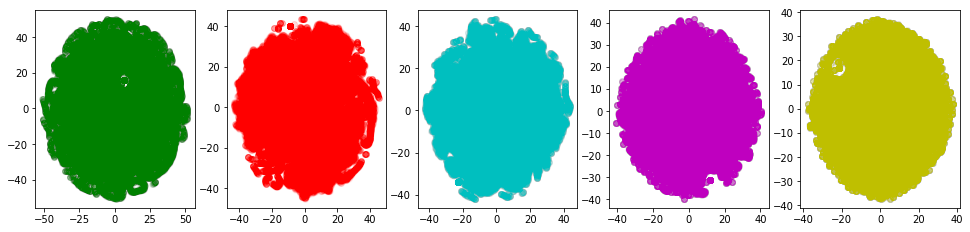

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))

j = 1
for i in data_array:
    plt.subplot(2, 6, j)
    plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1], color="bgrcmykbgrcmyk"[j], alpha=0.01)
    j = j+1
#    np.shape(Uembedded_list[i])
    #plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1],alpha=.2)

plt.show()

The graphs indicate very little clustering into sub-structures for related topics. Perhaps different values of `k` will yield more informative graphs, and it would also be worthwhile to split the posts to see different results across answers and questions.

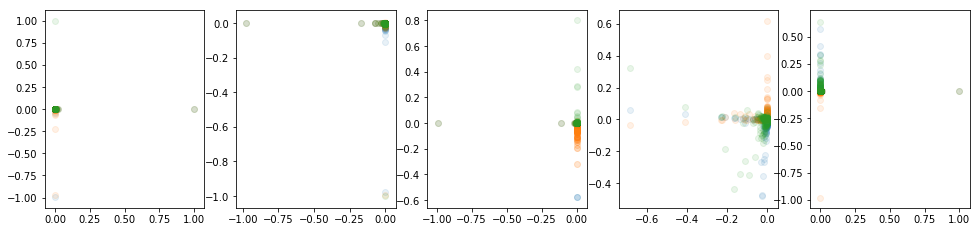

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))

j = 1
for i in data_array:
    plt.subplot(2, 6, j)
    plt.scatter(Uarray_list[i][:,0],Uarray_list[i][:,1],alpha=.1)
    plt.scatter(Uarray_list[i][:,0],Uarray_list[i][:,2],alpha=.1)
    plt.scatter(Uarray_list[i][:,0],Uarray_list[i][:,3],alpha=.1)
    j = j+1
#    np.shape(Uembedded_list[i])
    #plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1],alpha=.2)

plt.show()

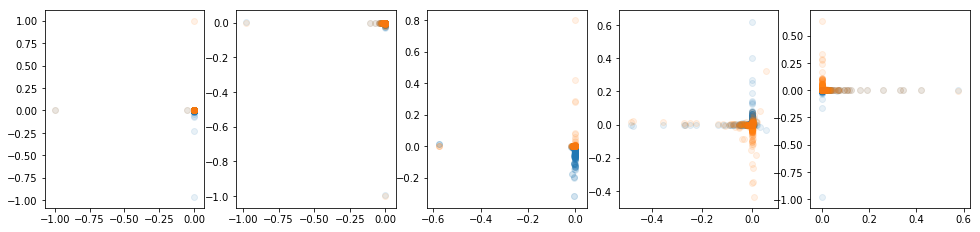

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))

j = 1
for i in data_array:
    plt.subplot(2, 6, j)
    plt.scatter(Uarray_list[i][:,1],Uarray_list[i][:,2],alpha=.1)
    plt.scatter(Uarray_list[i][:,1],Uarray_list[i][:,3],alpha=.1)
    j = j+1
#    np.shape(Uembedded_list[i])
    #plt.scatter(Uembedded_list[i][:,0],Uembedded_list[i][:,1],alpha=.2)

plt.show()

In the above two cells,  we plot the columns of `U` against one another. From the graphs we see that few posts account for large fractions of variability across all five fora.

## Latent Dirichlet Allocation

In a seminal paper, Blei *et al.* (2003) introduced latent Dirichlet Allocation (LDA) as a generative probabilistic model that can be used to model hidden topics in text corpora. LDA is able to represent the underlying semantic structure of a collection of documents by modeling topics as probability distributions over words, and thus can infer the set of topics for the collection of documents.

I start by choosing to build and LDA model across fora using `k=10` topics and then present the topics found.

In [108]:
## start time
t0 = time.time()
print(datetime.now().time())

## fit LDA models with k=10 topics
from pyspark.ml.clustering import LDA

lda = LDA(k=10, maxIter=5)

lda_model_list = {}
for i in data_array:
    lda_model_list[i] = lda.fit(word_feat_list[i])

## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - 2 minutes all-5  

18:23:04.732899
Time taken: 2 minutes.


In the cell below I calculate the perplexity and likelihood for each forum's model.

Perplexity can be used to compare different models as it measures how well a probability model predicts on a sample. A low perplexity value indicates the model predicts the sample well.

In [112]:
## start time
t0 = time.time()
print(datetime.now().time())

loglik_list = {}
logper_list = {}
for i in data_array:
    loglik_list[i] = lda_model_list[i].logLikelihood(word_feat_list[i])
    logper_list[i] = lda_model_list[i].logPerplexity(word_feat_list[i])
    print("Finished", i, "at", datetime.now().time())
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - ? minutes all-5  

18:39:18.887396
Finished codegolf
Finished codereview
Finished es_stackoverflow
Finished physics
Finished unix
Time taken: 85 minutes.


**Note:** As can be seen, the above command took 85 minutes to run. Look at how many cores the master node was using during this query satisfyingly gives us the following picture, where we can see all cores are being used maximally:

<img src="img/htop-screenshot-3.png" style="width: 900px;" alt="big data htop two cores">

In [113]:
for i in data_array:
    print("The lower bound on the log likelihood of the " +'\033[1m'+ i +'\033[0m'+ " corpus is: " + str(loglik_list[i]))
    print("The upper bound on the perplexity of the " +'\033[1m'+ i +'\033[0m'+ " corpus is: " + str(logper_list[i]))
    print('\n')

The lower bound on the log likelihood of the codegolf corpus is: -37118732.90254843
The upper bound on the perplexity of the codegolf corpus is: 9.868636466508827


The lower bound on the log likelihood of the codereview corpus is: -102395695.56387123
The upper bound on the perplexity of the codereview corpus is: 11.336194243969102


The lower bound on the log likelihood of the es_stackoverflow corpus is: -83887806.8079833
The upper bound on the perplexity of the es_stackoverflow corpus is: 11.117048003170803


The lower bound on the log likelihood of the physics corpus is: -63985360.86148716
The upper bound on the perplexity of the physics corpus is: 10.048667306255812


The lower bound on the log likelihood of the unix corpus is: -75396591.61435904
The upper bound on the perplexity of the unix corpus is: 10.794835581531835




From the results we see the order in which the probability model fits the fora the best is: `codegolf`; `physics`; `unix`; `es_stackoverflow`; `codereview`. Further work could explore the linguistic reasons for why the order of fora is as such.

In [114]:
## start time
t0 = time.time()
print(datetime.now().time())

## describe topics
topic_list = {}
for i in data_array:
    print("\n------------------\n", i, "\n------------------\n")
    topic_list[i] = lda_model_list[i].describeTopics(5)
    #print("The topics described by their top-weighted terms:\n")
    #topic_list[i].show(truncate=False)
    # show the results
    topic_j = topic_list[i].select("termIndices").rdd.map(lambda r: r[0]).collect()
    for j in topic_j:
        print(np.array(cntvcr_models[i].vocabulary)[j])
    print('\n')
    
## end time
T = time.time() - t0;
print("Time taken:", round(T/60), "minutes.") # hm96 - ? minutes all-5  

20:04:44.002901

------------------
 codegolf 
------------------

['bottle' 'wall' 'beer' 'symbol' 'ord']
['blub' 'tbody' 'gold' 'thead' 'coin']
['quot' 'bzzt' 'nodejs' 'cycle' 'hash']
['an' 'langr' 'octave' 'brachylog' 'wwwrprojectorg']
['ho' 'rand' 'powershell' 'maze' 'oooooo']
['blue' 'green' 'iw' 'nb' 'yellow']
['tp' 'circle' 'func' 'target' 'log']
['langhs' 'eax' 'dyalog' 'col' 'db']
['hi' 'langhtml' 'snippetcodehtml' 'langphp' 'cout']
['passenger' 'japt' 'listof' 'testdata' 'al']



------------------
 codereview 
------------------

['kbd' 'exp' 'nbsp' 'medium' 'radius']
['layout' 'iterable' 'nn' 'pow' 'permutation']
['allocator' 'sizetype' 'constiterator' 'alloc' 'playablespaces']
['dealer' 'palindrome' 'xsl' 'needle' 'swwriteline']
['actor' 'patient' 'damage' 'widget' 'boolboard']
['sieve' 'usize' 'mask' 'pub' 'setw']
['snake' 'coin' 'money' 'ball' 'pivot']
['nums' 'ajax' 'dx' 'maze' 'uid']
['df' 'blah' 'bigdecimal' 'currency' 'singleton']
['listnode' 'sf' 'userinput' 'salt' 

Lastly, the first 5 words of the 10 topics from the LDA models per forum are shown above. Some interesting aspects include:

* A common coding-problem on the forum `codegolf` is writing variations of the [99 Bottles of Beer program](http://99-bottles-of-beer.net) in different programming languages, and the first topic of this forum relates to this
* The `codereview` has an interesting topic relating to 'actor', 'patient', 'damage', 'widget', one relating to 'sieve', 'usize', 'mask', 'pub', and another relating to 'snake', 'coin', 'money', 'ball'.
* Very fittingly for this entire project, the `unix` forum exhibits a topic concerning 'hadoop' and 'hive'.

## Conclusion and further research

While this project did not tackle the original planned goal of analysing how the largest 20 StackExchange communities interact with questions by building an LDA classification model to predict on positive community engagement, much was learned not only about descriptive aspects of the data, but also the different avenues available to address computation sluggishness and to cost-effectively run a GCP Dataproc cluster.

It appears that there is substantial heterogeneity across the fora, owing to the results from the EDA and LDA perplexity and likelihood results. It is highly recommended that further analysis split the posts into questions and answers respectively to repeat the analysis to see differences across these two classes.

This notebook was also constructed so that it contains all the information and code needed to reproduce the the analysis with the same or different StackExchange datasets, from downloading and loading in the data to a GCP bucket to running the exploratory analysis.

Further research could address the computation difficulties when reading in and querying the data by exploring the following:

* Further optimising PySpark code
* Accessing the data directly from HDFS rather than a GCP Bucket
* Submit Spark jobs from the terminal using the entire analysis in a .py file rather than from this Jupyter notebook
* Use Google BigQuery to query the already-loaded StackOverflow forum data

In this way, larger datasets could be analysed with more complex queries and modeling.

In conclusion, this analysis was highly valuable in terms of learning about the nuances and intricacies of distributed computing technologies and my future research will continue to build on the infrastructure I have laid out here.

## References

Armbrust, M., Xin, R.S., Lian, C., Huai, Y., Liu, D., Bradley, J.K., Meng, X., Kaftan, T., Franklin, M.J., Ghodsi, A. and Zaharia, M., 2015, May. Spark sql: Relational data processing in spark. In *Proceedings of the 2015 ACM SIGMOD international conference on management of data* (pp. 1383-1394). ACM.

Blei, D.M., Ng, A.Y. and Jordan, M.I., 2003. Latent dirichlet allocation. *Journal of machine Learning research*, 3(Jan), pp.993-1022.

Deerwester, S., Dumais, S.T., Furnas, G.W., Landauer, T.K. and Harshman, R., 1990. Indexing by latent semantic analysis. *Journal of the American society for information science*, 41(6), pp.391-407.

Laskowski, J., 2019. *The Internals of Apache Spark.* Available at: https://www.learningjournal.guru/article/apache-spark/apache-spark-internals/

Maaten, L.V.D. and Hinton, G., 2008. Visualizing data using t-SNE. *Journal of machine learning research*, 9(Nov), pp.2579-2605.

Sato, K., 2012. An inside look at google bigquery. *White paper, URL: https://cloud.google.com/files/BigQueryTechnicalWP.pdf.*

Zaharia, M., Chowdhury, M., Das, T., Dave, A., Ma, J., McCauley, M., Franklin, M.J., Shenker, S. and Stoica, I., 2012, April. Resilient distributed datasets: A fault-tolerant abstraction for in-memory cluster computing. In *Proceedings of the 9th USENIX conference on Networked Systems Design and Implementation* (pp. 2-2). USENIX Association.